Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import GitHub repository

In [2]:
import os

if not os.path.isdir('tanogan'):
  !git clone https://github.com/sergiuabed/tanogan
else:
  %cd tanogan/
  !git pull
  %cd ..

Cloning into 'tanogan'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 41 (delta 18), reused 34 (delta 11), pack-reused 0
Receiving objects: 100% (41/41), 8.43 KiB | 4.21 MiB/s, done.
Resolving deltas: 100% (18/18), done.


# Imports

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import datetime
from sklearn.model_selection import train_test_split
from tanogan.data_utils.data_utils import get_df_action, get_standardizer, standardization
from tanogan.architecture import init_generator, init_discriminator
from tanogan.training import adversarial_training

# Load Dataset
Load dataset locally from Google Drive

IMPORTANT: NOT ALL SAMPLES IN **df_action_anomalous_rec#** ARE ANOMALOUS. HENCE, LATER ON , WHEN DIVIDING THE DATASET IN WINDOWS, NOT ALL WINDOWS OBTAINED FROM **df_action_anomalous** ARE ANOMALOUS. PLEASE, REMEMBER THIS WHILE READING THE CODE

In [4]:
if not os.path.isdir('csv_20220811-20220927T082743Z-001'):
  !cp -R /content/drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/csv_20220811-20220927T082743Z-001/ .

path = './csv_20220811-20220927T082743Z-001/csv_20220811'

# Load normal (non-anomalous) data
filepath_csv = [os.path.join(path, f"rec{r}_20220811_rbtc_0.1s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(path, f"rec{r}_20220811_rbtc_0.1s.metadata") for r in [0, 2, 3, 4]]
df_action_regular, df_regular, df_meta_regular, action2int_regular = get_df_action(filepath_csv, filepath_meta)

# Load anomalous data
filepath_csv_rec1 = [os.path.join(path, f"rec{r}_collision_20220811_rbtc_0.1s.csv") for r in [1]]
filepath_csv_rec5 = [os.path.join(path, f"rec{r}_collision_20220811_rbtc_0.1s.csv") for r in [5]]

filepath_meta_rec1 = [os.path.join(path, f"rec{r}_collision_20220811_rbtc_0.1s.metadata") for r in [1]]
filepath_meta_rec5 = [os.path.join(path, f"rec{r}_collision_20220811_rbtc_0.1s.metadata") for r in [5]]

df_action_rec1, df_rec1, df_meta_rec1, action2int_rec1 = get_df_action(filepath_csv_rec1, filepath_meta_rec1)
df_action_rec5, df_rec5, df_meta_rec5, action2int_rec5 = get_df_action(filepath_csv_rec5, filepath_meta_rec5)

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



In [5]:
print(df_action_regular.columns)
print(df_regular.columns)

Index(['machine_nameKuka Robot_apparent_power',
       'machine_nameKuka Robot_current',
       'machine_nameKuka Robot_export_reactive_energy',
       'machine_nameKuka Robot_frequency',
       'machine_nameKuka Robot_import_active_energy',
       'machine_nameKuka Robot_phase_angle', 'machine_nameKuka Robot_power',
       'machine_nameKuka Robot_power_factor',
       'machine_nameKuka Robot_reactive_power',
       'machine_nameKuka Robot_voltage', 'sensor_id1_AccX', 'sensor_id1_AccY',
       'sensor_id1_AccZ', 'sensor_id1_AngX', 'sensor_id1_AngY',
       'sensor_id1_AngZ', 'sensor_id1_GyroX', 'sensor_id1_GyroY',
       'sensor_id1_GyroZ', 'sensor_id2_AccX', 'sensor_id2_AccY',
       'sensor_id2_AccZ', 'sensor_id2_AngX', 'sensor_id2_AngY',
       'sensor_id2_AngZ', 'sensor_id2_GyroX', 'sensor_id2_GyroY',
       'sensor_id2_GyroZ', 'sensor_id3_AccX', 'sensor_id3_AccY',
       'sensor_id3_AccZ', 'sensor_id3_AngX', 'sensor_id3_AngY',
       'sensor_id3_AngZ', 'sensor_id3_GyroX', 'sensor_

# Data Preprocessing

Drop some columns and standardize the data

In [6]:
# drop non-numerical columns
df_regular = df_regular.drop(["time"], axis=1)
df_rec1 = df_rec1.drop(["time"], axis=1)
df_rec5 = df_rec5.drop(["time"], axis=1)

# standardize data
standardizer = get_standardizer(df_regular)

df_regular_normal = standardization(df_regular, standardizer)
df_rec1_normal = standardization(df_rec1, standardizer)
df_rec5_normal = standardization(df_rec5, standardizer)

In [7]:
df_regular_normal.sort_index().head(2000).tail(10)

,machine_nameKuka Robot_apparent_power,machine_nameKuka Robot_current,machine_nameKuka Robot_export_reactive_energy,machine_nameKuka Robot_frequency,machine_nameKuka Robot_import_active_energy,machine_nameKuka Robot_phase_angle,machine_nameKuka Robot_power,machine_nameKuka Robot_power_factor,machine_nameKuka Robot_reactive_power,machine_nameKuka Robot_voltage,...,sensor_id4_GyroZ,sensor_id5_AccX,sensor_id5_AccY,sensor_id5_AccZ,sensor_id5_AngX,sensor_id5_AngY,sensor_id5_AngZ,sensor_id5_GyroX,sensor_id5_GyroY,sensor_id5_GyroZ
time,,,,,,,,,,,,,,,,,,,,,
2022-08-11 13:12:04.619,-1.078706,-1.941294,-1.696565,0.373132,-1.716024,0.417577,-0.830938,0.443463,2.486926,-0.435902,...,-0.700328,-0.251223,0.095296,0.078541,-0.176864,1.093616,0.517093,1.236690,-0.728666,-0.784789
2022-08-11 13:12:04.719,-1.078706,-1.941294,-1.696565,0.373132,-1.716024,0.417577,-0.830938,0.443463,2.486926,-0.435902,...,-0.700328,-0.251424,0.095296,0.078036,-0.176864,1.093995,0.516707,-0.816528,-0.728697,-0.784789
2022-08-11 13:12:04.819,-1.078706,-1.941294,-1.696565,0.373132,-1.716024,0.417577,-0.830938,0.443463,2.486926,-0.435902,...,-0.700328,-0.251223,0.095059,0.078288,-0.176263,1.094373,0.516321,-0.816497,-0.728634,-0.784789
2022-08-11 13:12:04.919,-1.078706,-1.941294,-1.696565,0.373132,-1.716024,0.417577,-0.830938,0.443463,2.486926,-0.435902,...,-0.700328,-0.251223,0.095059,0.078036,-0.176263,1.094373,0.516031,-0.816528,-0.728666,-0.784789
2022-08-11 13:12:05.019,-1.078706,-1.941294,-1.696565,0.373132,-1.716024,0.417577,-0.830938,0.443463,2.486926,-0.435902,...,1.442750,-0.253036,0.094585,0.077783,-0.176263,1.094751,0.515741,1.236628,-0.728697,-0.784789
2022-08-11 13:12:05.119,-1.078706,-1.941294,-1.696565,0.373132,-1.716024,0.417577,-0.830938,0.443463,2.486926,-0.435902,...,-0.700328,-0.250820,0.095296,0.078794,-0.176864,1.094751,0.515548,-0.816558,-0.728697,-0.784789
2022-08-11 13:12:05.219,-1.078706,-1.941294,-1.696565,0.373132,-1.716024,0.417577,-0.830938,0.443463,2.486926,-0.435902,...,-0.700328,-0.252230,0.094822,0.076771,-0.176864,1.095130,0.515259,-0.816558,-0.728697,-0.784789
2022-08-11 13:12:05.319,-1.078706,-1.941294,-1.696565,-1.284248,-1.716024,0.417577,-0.830938,0.443463,2.486926,-0.435902,...,-0.700328,-0.250820,0.094822,0.078288,-0.176263,1.095130,0.514969,-0.816558,-0.728697,-0.784789
2022-08-11 13:12:05.419,-1.078706,-1.941294,-1.696565,-1.284248,-1.716024,0.417577,-0.830938,0.443463,2.486926,-0.435902,...,-0.690812,6.040356,0.076572,0.126338,-0.164252,1.079615,0.513618,-0.815619,-0.722438,1.289187


## Read "20220811_collisions_timestamp.xlsx" and create a dataframe with a row for each anomalous time interval

In [8]:
def get_anomalous_intervals(path, sheet_names):
    # outputs dataframe with:
    #   - index: 0, 1, 2, 3, ...
    #   - columns: "start_timestamp", "end_timestamp"
    # Each row in this dataframe corresponds to a certain anomaly interval
    df_list = []
    begin_index = 0
    for sn in sheet_names:
        rec_collision_timestamps_excel = pd.read_excel(path, sheet_name=sn)

        starts = rec_collision_timestamps_excel.iloc[::2]
        starts.index = [i + begin_index for i in range(len(starts.index))]
        starts = starts.rename(columns={"Timestamp": "start_timestamp"})
        starts['start_timestamp'] = starts['start_timestamp'] - pd.Timedelta(hours=2) # anticipate 2 hours mismatch

        stops = rec_collision_timestamps_excel.iloc[1::2]
        stops.index = [i + begin_index for i in range(len(stops.index))]
        stops = stops.rename(columns={"Timestamp": "end_timestamp"})
        stops['end_timestamp'] = stops['end_timestamp'] - pd.Timedelta(hours=2) # anticipate 2 hours mismatch

        anomalous_intervals = pd.concat([starts, stops], axis=1)

        anomalous_intervals.drop('Inizio/fine', axis=1, inplace=True)
        df_list.append(anomalous_intervals)

        begin_index += len(stops.index)

    all_anomalous_intervals = pd.concat(df_list)
    return all_anomalous_intervals

anomalous_intervals = get_anomalous_intervals("./csv_20220811-20220927T082743Z-001/csv_20220811/20220811_collisions_timestamp.xlsx", ["rec1", "rec5"])

anomalous_intervals

,start_timestamp,end_timestamp
0,2022-08-11 14:02:17.450,2022-08-11 14:02:21.460
1,2022-08-11 14:02:28.320,2022-08-11 14:02:31.420
2,2022-08-11 14:02:45.770,2022-08-11 14:02:49.660
3,2022-08-11 14:02:57.490,2022-08-11 14:02:59.390
4,2022-08-11 14:03:56.960,2022-08-11 14:03:58.700
...,...,...
102,2022-08-11 17:01:56.990,2022-08-11 17:02:01.160
103,2022-08-11 17:02:11.180,2022-08-11 17:02:15.340
104,2022-08-11 17:02:58.080,2022-08-11 17:03:02.080
105,2022-08-11 17:03:44.090,2022-08-11 17:03:48.150


In [9]:
def label_timestamps(df, anomalous_intervals):

  cumulative_flag = np.array([False for d in df.index])

  for interval in anomalous_intervals.values:
    flag = np.array([(interval[0] < d and interval[1] > d) for d in df.index])
    cumulative_flag = cumulative_flag + flag  # element-wise OR operation

  df_label = df.copy()
  df_label.insert(0, "anomaly", [0 for _ in range(len(df.index))], True)
  df_label.loc[cumulative_flag.tolist(), "anomaly"] = 1

  return df_label

df_regular_labelled = label_timestamps(df_regular_normal, anomalous_intervals)
df_rec1_labelled = label_timestamps(df_rec1_normal, anomalous_intervals)
df_rec5_labelled = label_timestamps(df_rec5_normal, anomalous_intervals)

df_rec1_labelled.loc[df_rec1_labelled['anomaly']==0]

,anomaly,machine_nameKuka Robot_apparent_power,machine_nameKuka Robot_current,machine_nameKuka Robot_export_reactive_energy,machine_nameKuka Robot_frequency,machine_nameKuka Robot_import_active_energy,machine_nameKuka Robot_phase_angle,machine_nameKuka Robot_power,machine_nameKuka Robot_power_factor,machine_nameKuka Robot_reactive_power,...,sensor_id4_GyroZ,sensor_id5_AccX,sensor_id5_AccY,sensor_id5_AccZ,sensor_id5_AngX,sensor_id5_AngY,sensor_id5_AngZ,sensor_id5_GyroX,sensor_id5_GyroY,sensor_id5_GyroZ
time,,,,,,,,,,,,,,,,,,,,,
2022-08-11 14:01:34.644,0,-1.659778,-1.249082,-0.902503,0.373132,-0.903120,-2.896849,-1.879994,-3.157673,0.130060,...,-0.700328,-0.250820,0.095296,0.078288,-0.175062,1.097400,1.480228,-0.816558,-0.728697,-0.784789
2022-08-11 14:01:34.744,0,-1.659778,-1.249082,-0.902503,0.373132,-0.903120,-2.896849,-1.879994,-3.157673,0.130060,...,-0.700328,-0.251021,0.095296,0.078288,-0.175062,1.097400,1.480228,-0.816558,-0.728697,-0.784789
2022-08-11 14:01:34.844,0,-1.659778,-1.249082,-0.902503,0.373132,-0.903120,-2.896849,-1.879994,-3.157673,0.130060,...,-0.700328,-0.250820,0.095059,0.078288,-0.175062,1.097400,1.480228,-0.816558,-0.728697,-0.784789
2022-08-11 14:01:34.944,0,-1.659778,-1.249082,-0.902503,0.373132,-0.903120,-2.896849,-1.879994,-3.157673,0.130060,...,-0.700328,-0.251424,0.095770,0.078036,-0.175062,1.097400,1.480228,-0.816558,-0.728697,-0.784789
2022-08-11 14:01:35.044,0,-1.659778,-1.249082,-0.902503,0.373132,-0.903120,-2.896849,-1.879994,-3.157673,0.130060,...,-0.700328,-0.251021,0.095296,0.078036,-0.175062,1.097400,1.480228,-0.816558,-0.728697,-0.784789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-11 14:30:30.744,0,0.967267,1.377899,-0.442150,0.373132,-0.428394,0.596178,0.911731,0.607155,-1.151908,...,1.422573,6.045191,0.125160,0.078036,-0.057356,0.761747,1.586996,1.225725,1.358975,-0.767006
2022-08-11 14:30:30.844,0,0.967267,1.377899,-0.442150,0.373132,-0.428394,0.596178,0.911731,0.607155,-1.151908,...,1.424142,-0.257468,0.109043,0.163513,-0.175062,0.964199,1.603697,1.230612,1.364754,-0.776864
2022-08-11 14:30:30.944,0,0.967267,1.377899,-0.442150,0.373132,-0.428394,0.596178,0.911731,0.607155,-1.151908,...,1.436010,-0.233696,0.079653,0.121027,-0.205690,1.047071,1.614895,1.233559,1.376755,-0.783076


# Hyperparameters

In [10]:
DATASET_FREQUENCY = 10 #Hz
WINDOW_TIME = 6 #seconds
WINDOW_SIZE = DATASET_FREQUENCY * WINDOW_TIME # nr of samples in a window
SAMPLE_SIZE = 55# df_regular_labelled.iloc[0].shape[0] - 1 # df_regular_labelled has column "anomaly", which shall not be used for training
LATENT_VAR_SIZE = SAMPLE_SIZE
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 1
EPOCHS = 20
LAMBDA = 0.1
NR_LATENT_MAP_ITERS = 50

training_loss = tf.keras.losses.BinaryCrossentropy()
#discr_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
#gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

discr_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

z_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002) # optimizer for used for mapping to latent space


In [11]:
SAMPLE_SIZE

55

## Window the data

In [12]:
def window_data(df, window_size, shift=1): # window_size refers to the nr of samples in a window
  df.sort_index(inplace=True)
  #df.index = [i for i in range(len(df.index))]

  windows_list = []
  label_list = []

  for i in range(0, len(df.index), shift):
    if i + window_size <= len(df.index):
      window = df.iloc[i : i + window_size].copy()

      nr_anomalies = window['anomaly'].sum()

      if nr_anomalies > 0:
        #print(f"This happened! nr_anomalies={nr_anomalies}")
        label_list.append(1)
      else:
        label_list.append(0)

      window = window.drop(["anomaly"], axis=1).to_numpy()

      windows_list.append(window)
      #print(len(windows_list))

  return np.array(windows_list), np.array(label_list)
  #return windows_list, label_list

windows_regular, labels_regular = window_data(df_regular_labelled, WINDOW_SIZE, 1)
print()
windows_rec1, labels_rec1 = window_data(df_rec1_labelled, WINDOW_SIZE, WINDOW_SIZE)
windows_rec5, labels_rec5 = window_data(df_rec5_labelled, WINDOW_SIZE, WINDOW_SIZE)


In [13]:
print(f"Nr samples in df_regular_labelled: {df_regular_labelled.shape}")
print(f"Nr of windows in windows_regular: {windows_regular.shape}\n")

print(f"Nr samples in df_rec1_labelled: {df_rec1_labelled.shape}")
print(f"Nr of windows in windows_rec1: {windows_rec1.shape}\n")

print(f"Nr samples in df_rec5_labelled: {df_rec5_labelled.shape}")
print(f"Nr of windows in windows_rec5: {windows_rec5.shape}\n")

print(f"Nr of anomalous windows in windows_regular: {windows_regular[labels_regular==1].shape[0]}")
print(f"Nr of anomalous windows in windows_rec1: {windows_rec1[labels_rec1==1].shape[0]}")
print(f"Nr of anomalous windows in windows_rec5: {windows_rec5[labels_rec5==1].shape[0]}")

Nr samples in df_regular_labelled: (95815, 56)
Nr of windows in windows_regular: (95756, 60, 55)

Nr samples in df_rec1_labelled: (17366, 56)
Nr of windows in windows_rec1: (289, 60, 55)

Nr samples in df_rec5_labelled: (16909, 56)
Nr of windows in windows_rec5: (281, 60, 55)

Nr of anomalous windows in windows_regular: 0
Nr of anomalous windows in windows_rec1: 53
Nr of anomalous windows in windows_rec5: 121


In [ ]:
del df_regular, df_regular_normal, df_regular_labelled, df_rec1, df_rec1_normal, df_rec1_labelled, df_rec5, df_rec5_normal, df_rec5_labelled

# Dataset

Make TensorFlow Dataset

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((windows_regular, labels_regular)).map(lambda x, y: (tf.cast(x, tf.float32), y)).batch(TRAIN_BATCH_SIZE)
validation_dataset = tf.data.Dataset.from_tensor_slices((windows_rec5, labels_rec5)).map(lambda x, y: (tf.cast(x, tf.float32), y)).batch(TEST_BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((windows_rec1, labels_rec1)).map(lambda x, y: (tf.cast(x, tf.float32), y)).batch(TEST_BATCH_SIZE)

# Generator and Discriminator instantiation

In [ ]:
generator = init_generator(in_dim=(WINDOW_SIZE, LATENT_VAR_SIZE), out_dim=(WINDOW_SIZE, SAMPLE_SIZE))
discriminator = init_discriminator(in_dim=(WINDOW_SIZE, SAMPLE_SIZE), out_dim=1)

# Training

In [ ]:
def adversarial_training(generator, discriminator, data, batch_size, windows_size, loss_fn, discr_optimizer, gen_optimizer, checkpoints_backup_path, num_epochs=1):

# setup checkpoint saving
  directory_path = "./checkpoints"

  filepath_generator = directory_path + "/generator/"
  filepath_discriminator = directory_path + "/discriminator/"

  if not os.path.isdir('checkpoints'):
    ! mkdir checkpoints

    ! mkdir {filepath_generator}
    ! mkdir {filepath_discriminator}

  real_label = 0
  fake_label = 1

  print("epoch: 0/%d")
  for epoch in range(num_epochs):
    for i, (time_sequences, labels) in enumerate(data):
      # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))

      #Train with real data
      with tf.GradientTape() as tape:
        scores = discriminator(time_sequences)
        discr_real_loss = loss_fn(labels, scores)

      gradients = tape.gradient(discr_real_loss, discriminator.trainable_weights)
      discr_optimizer.apply_gradients(zip(gradients, discriminator.trainable_weights))

      #Train with fake data
      noise = tf.random.normal(time_sequences.shape, mean=0, stddev=0.1)
      fake_sequences = generator(noise)
      fake_labels = tf.ones(labels.shape) * fake_label

      with tf.GradientTape() as tape:
          scores = discriminator(fake_sequences)
          discr_fake_loss = loss_fn(fake_labels, scores)

      gradients = tape.gradient(discr_fake_loss, discriminator.trainable_weights)
      discr_optimizer.apply_gradients(zip(gradients, discriminator.trainable_weights))


      # (2) Update G network: maximize log(D(G(z)))

      noise = tf.random.normal(time_sequences.shape, mean=0, stddev=0.1)
      with tf.GradientTape() as tape:
        fake_sequences = generator(noise)
        #real_labels = tf.ones(noise.shape)
        discriminator_output = discriminator(fake_sequences)    # discriminator tells which fake sequences it considers to be real and which not
        generator_loss = loss_fn(labels, discriminator_output)

      gradients = tape.gradient(generator_loss, generator.trainable_weights)
      gen_optimizer.apply_gradients(zip(gradients, generator.trainable_weights))

      print(
          f"epoch: {epoch}/{num_epochs},    batch: {i}/{len(data)}    Discriminator_loss: {discr_real_loss+discr_fake_loss}  Generator_loss: {generator_loss}"
      )

    generator.save_weights(filepath_generator + f"gen_epoch{epoch}.h5")
    discriminator.save_weights(filepath_discriminator + f"discr_epoch{epoch}.h5")

    # zip and move a copy of the checkpoints
    now = datetime.datetime.now()
    zip_name = f"checkpoints_{str(now.date())+'_'+str(now.time())}.zip"

    !zip -r {zip_name} ./checkpoints
    !cp {zip_name} {checkpoints_backup_path}

#    gen_symbolic_weights = getattr(gen_optimizer, 'weights')  # save gen_optimizer parameters
#    weight_values = K.batch_get_value(gen_symbolic_weights)
#    with open(f'checkpoints/generator/gen_optimizer_epoch{epoch}.pkl', 'wb') as f:
#      pickle.dump(weight_values, f)
#
#    discr_symbolic_weights = getattr(discr_optimizer, 'weights')  # save discr_optimizer parameters
#    weight_values = K.batch_get_value(discr_symbolic_weights)
#    with open(f'checkpoints/discriminator/discr_optimizer_epoch{epoch}.pkl', 'wb') as f:
#      pickle.dump(weight_values, f)

In [ ]:
adversarial_training(generator, discriminator, train_dataset, TRAIN_BATCH_SIZE, WINDOW_SIZE, training_loss, discr_optimizer, gen_optimizer, "./drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/saved_checkpoints", 20)

epoch: 0/%d


Streaming output truncated to the last 5000 lines.
epoch: 18/20,    batch: 1070/2993    Discriminator_loss: -0.0  Generator_loss: 15.33323860168457
epoch: 18/20,    batch: 1071/2993    Discriminator_loss: -0.0  Generator_loss: 15.33323860168457
epoch: 18/20,    batch: 1072/2993    Discriminator_loss: -0.0  Generator_loss: 15.33323860168457
epoch: 18/20,    batch: 1073/2993    Discriminator_loss: -0.0  Generator_loss: 15.33323860168457
epoch: 18/20,    batch: 1074/2993    Discriminator_loss: -0.0  Generator_loss: 15.33323860168457
epoch: 18/20,    batch: 1075/2993    Discriminator_loss: -0.0  Generator_loss: 15.33323860168457
epoch: 18/20,    batch: 1076/2993    Discriminator_loss: -0.0  Generator_loss: 15.33323860168457
epoch: 18/20,    batch: 1077/2993    Discriminator_loss: -0.0  Generator_loss: 15.33323860168457
epoch: 18/20,    batch: 1078/2993    Discriminator_loss: -0.0  Generator_loss: 15.33323860168457
epoch: 18/20,    batch: 1079/2993    Discriminator_loss: -0.0  Generator_los

In [ ]:
!zip -r ./checkpoints ./checkpoints
!cp ./checkpoints.zip ./drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/saved_checkpoints

# Anomaly Detection

In [ ]:
#anomaly_score(test_dataset, generator, discriminator, z_optimizer, NR_LATENT_MAP_ITERS, LAMBDA)

TypeError: ignored

In [ ]:
def z_loss(time_sequences, fake_sequences, discriminator, _lambda):
  '''
  This function acts as both loss function when mapping a time sequence to
  a latent variable 'z' and as anomaly score.

  This loss is the sum of 2 losses:
      - residual loss: the sum of the absolute value of the components of the difference
          between a real time sequence and a generated one by the generator

      - discrimination loss: the sum of the absolute value of the components of the difference
          between the outputs of the LSTM layer of the discriminator when the inputs
          are a real time sequence and a generated one
  '''
    #residual_loss = tf.reduce_sum(abs(tf.cast(time_sequences, tf.double) - tf.cast(fake_sequences, tf.double))) # casting both to tf.double because of an error
  residual_loss = tf.reduce_sum(abs(time_sequences - fake_sequences))

  interm_layer = discriminator.layers[0]  # LSTM layer

  features_real = interm_layer(time_sequences)
  features_fake = interm_layer(fake_sequences)

  discrimination_loss = tf.reduce_sum(abs(features_real-features_fake))

  total_loss = (1-_lambda)*residual_loss + _lambda*discrimination_loss

  return total_loss

def latent_space_map(time_sequences, num_iters, generator, discriminator, z_optimizer, _lambda):
  '''
  Maps a batch of time sequences to the latent space

  Because the generator's mapping function G(z) from latent space
  to the space of realistic time sequences is not invertible,
  we must leverage gradient descent to find a latent space value 'z'
  such that G(z) is as close as possible to a given time sequence 'x'

  return: the loss between 'time_sequences' and G(z), where 'z' is
  the latent variable value found after 'num_iters' iterations of
  performing gradient descent.
  '''

  print(f"Shape of time_sequences: {time_sequences.shape}")

  z = tf.Variable(tf.random.normal(time_sequences.shape, mean=0, stddev=0.1))
  i=0
  for _ in range(num_iters):
    print(f"  iteration: {i}")
    i+=1

    loss = None
    with tf.GradientTape() as tape:
      generated_sequences = generator(z)
      loss = z_loss(time_sequences, generated_sequences, discriminator, _lambda)
      print(f"    z_loss: {loss}")

    gradients = tape.gradient(loss, z)
    z_optimizer.apply_gradients(zip([gradients], [z]))

  # maybe compute the loss again before returning
  return loss

def anomaly_score(test_data, generator, discriminator, z_optimizer, nr_latent_map_iters, _lambda):
  '''
  Outputs a list of losses, each loss corresponding to a time window
  '''

  # IMPORTANT: DURING ANOMALY DETECTION, SET BATCH_SIZE=1!!!!!!!!!!!!!!!!!!
  # i.e., a batch contains a single window of timesteps

  i = 0
  loss_list = []
  for _, batch in enumerate(test_data):
    print(f"batch: {i} out of {len(test_data)}")
    i+=1

    loss_list.append(
      latent_space_map(batch[0], nr_latent_map_iters, generator, discriminator, z_optimizer, _lambda)
      ) # batch size is 1, so batch[0] points to the window

  return loss_list


In [ ]:
#all_anomalous_set = anomalous_windows[anomalous_labels==1].copy()
#all_anomalous_labels = np.array([1 for _ in range(len(all_anomalous_set))])
#all_anomalous_dataset = tf.data.Dataset.from_tensor_slices((all_anomalous_set, all_anomalous_labels)).map(lambda x, y: (tf.cast(x, tf.float32), y)).batch(1)

In [ ]:
#train_subset = train_set[ int(0.4*len(train_set)) : int(0.6*len(train_set)), : ].copy()
#train_sublabels = train_labels[ int(0.4*len(train_set)) : int(0.6*len(train_set)) ].copy()
#
#changed_train_dataset = tf.data.Dataset.from_tensor_slices((train_subset, train_sublabels)).map(lambda x, y: (tf.cast(x, tf.float32), y)).batch(1)

In [ ]:
!cp ./drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/saved_checkpoints/checkpoints.zip .
!unzip ./checkpoints.zip -d .

Archive:  ./checkpoints.zip
   creating: ./checkpoints/
   creating: ./checkpoints/discriminator/
  inflating: ./checkpoints/discriminator/discr_epoch0.h5  
  inflating: ./checkpoints/discriminator/discr_epoch6.h5  
  inflating: ./checkpoints/discriminator/discr_epoch4.h5  
  inflating: ./checkpoints/discriminator/discr_epoch5.h5  
  inflating: ./checkpoints/discriminator/discr_epoch9.h5  
  inflating: ./checkpoints/discriminator/discr_epoch2.h5  
  inflating: ./checkpoints/discriminator/discr_epoch8.h5  
  inflating: ./checkpoints/discriminator/discr_epoch3.h5  
  inflating: ./checkpoints/discriminator/discr_epoch1.h5  
  inflating: ./checkpoints/discriminator/discr_epoch7.h5  
   creating: ./checkpoints/generator/
  inflating: ./checkpoints/generator/gen_epoch2.h5  
  inflating: ./checkpoints/generator/gen_epoch7.h5  
  inflating: ./checkpoints/generator/gen_epoch8.h5  
  inflating: ./checkpoints/generator/gen_epoch6.h5  
  inflating: ./checkpoints/generator/gen_epoch1.h5  
  inflati

# Perform inference
Either use the generator and discriminator at the state you have them now (if you just trained them), or load a previously saved checkpoint

In [ ]:
generator = init_generator(in_dim=(WINDOW_SIZE, LATENT_VAR_SIZE), out_dim=(WINDOW_SIZE, SAMPLE_SIZE))
discriminator = init_discriminator(in_dim=(WINDOW_SIZE, SAMPLE_SIZE), out_dim=1)

!cp ./drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/saved_checkpoints/checkpoints_2023-07-24_02:06:38.210438.zip .
!unzip ./checkpoints_2023-07-24_02:06:38.210438.zip -d .

epoch = 19
generator.load_weights(f"./checkpoints/generator/gen_epoch{epoch}.h5")
discriminator.load_weights(f"./checkpoints/discriminator/discr_epoch{epoch}.h5")

In [ ]:
test_loss_list = anomaly_score(test_dataset, generator, discriminator, tf.keras.optimizers.legacy.Adam(learning_rate=0.02), 50, LAMBDA)

Streaming output truncated to the last 5000 lines.
  iteration: 49
    z_loss: 2940.534423828125
batch: 240 out of 289
Shape of time_sequences: (1, 60, 55)
  iteration: 0
    z_loss: 3271.653076171875
  iteration: 1
    z_loss: 3271.58251953125
  iteration: 2
    z_loss: 3271.486572265625
  iteration: 3
    z_loss: 3271.41748046875
  iteration: 4
    z_loss: 3271.26025390625
  iteration: 5
    z_loss: 3271.24365234375
  iteration: 6
    z_loss: 3292.62939453125
  iteration: 7
    z_loss: 2539.267333984375
  iteration: 8
    z_loss: 2231.199951171875
  iteration: 9
    z_loss: 2219.51806640625
  iteration: 10
    z_loss: 2212.65576171875
  iteration: 11
    z_loss: 2208.23681640625
  iteration: 12
    z_loss: 2204.99755859375
  iteration: 13
    z_loss: 2202.460205078125
  iteration: 14
    z_loss: 2200.377197265625
  iteration: 15
    z_loss: 2198.619384765625
  iteration: 16
    z_loss: 2197.0966796875
  iteration: 17
    z_loss: 2195.764892578125
  iteration: 18
    z_loss: 2194.5895

In [ ]:
test_loss_list

[<tf.Tensor: shape=(), dtype=float32, numpy=3506.4456>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3501.5425>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3480.163>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3486.938>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3101.8435>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3061.375>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2920.3882>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3130.5745>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3115.7664>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2997.5112>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3121.577>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2881.7795>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3090.5903>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2922.4402>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2901.8809>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3231.523>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2785.5586>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2833.078>

## Save in Drive the losses obtained on test or validation datasets

In [ ]:
test_loss_array = np.array([i.numpy().item() for i in test_loss_list])

with open('test_loss.npy', 'wb') as f:
  np.save(f, test_loss_array)

!cp ./test_loss.npy ./drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/saved_losses/

with open('test_loss.npy', 'rb') as f:
  reloaded_array = np.load(f)

reloaded_array

array([3506.44555664, 3501.54248047, 3480.16308594, 3486.93798828,
       3101.84350586, 3061.375     , 2920.38818359, 3130.57446289,
       3115.76635742, 2997.51123047, 3121.5769043 , 2881.77954102,
       3090.59033203, 2922.44018555, 2901.88085938, 3231.52294922,
       2785.55859375, 2833.07788086, 2268.58862305, 2922.76367188,
       3101.39160156, 3066.60693359, 2792.26635742, 3162.06420898,
       2834.92749023, 3101.33886719, 2873.46020508, 3139.93212891,
       2948.59741211, 3208.31030273, 3071.22924805, 2089.48754883,
       2925.17041016, 2001.68469238, 2835.82836914, 3179.02783203,
       2900.1105957 , 1943.00390625, 3161.93066406, 3249.64331055,
       3029.76293945, 3098.52734375, 3197.32910156, 2995.83251953,
       3044.55908203, 3264.17724609, 3063.4387207 , 3112.67749023,
       2911.69702148, 3086.31860352, 3128.02832031, 3417.61938477,
       2870.34960938, 2974.77563477, 3095.14672852, 3029.41992188,
       3383.43139648, 2989.55444336, 3169.38476562, 3351.56323

# Load saved losses and compute performance measures

In [14]:
!cp ./drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/saved_losses/test_loss.npy .
!cp ./drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/saved_losses/validation_loss.npy .

with open('test_loss.npy', 'rb') as f:
  test_loss = np.load(f)

with open('validation_loss.npy', 'rb') as g:
  validation_loss = np.load(g)

In [15]:
from sklearn.metrics import f1_score, precision_score, recall_score

def compute_f1_score(anomaly_scores, ground_truth, thresholds):
    f1_dict = {}

    for t in thresholds:
        assigned_labels = [0 if i < t else 1 for i in anomaly_scores]
        f1_dict[t] = f1_score(ground_truth, assigned_labels)

    return f1_dict

def compute_precision_score(anomaly_scores, ground_truth, thresholds):
    precision_dict = {}

    for t in thresholds:
        assigned_labels = [0 if i < t else 1 for i in anomaly_scores]
        precision_dict[t] = precision_score(ground_truth, assigned_labels)

    return precision_dict

def compute_recall_score(anomaly_scores, ground_truth, thresholds):
    recall_dict = {}

    for t in thresholds:
        assigned_labels = [0 if i < t else 1 for i in anomaly_scores]
        recall_dict[t] = recall_score(ground_truth, assigned_labels)

    return recall_dict

In [16]:
import matplotlib.pyplot as plt

def plot_metric(metric_results_dict, chosen_th, model_name, x_axis_descr, y_axis_descr):

  plt.figure().set_facecolor("w")
  plt.style.use('default')

  plt.title(model_name)
  plt.xlabel(x_axis_descr)
  plt.ylabel(y_axis_descr)

  plt.plot(metric_results_dict.keys(), metric_results_dict.values(), '-s', linewidth=1, markersize=2)

  plt.plot(chosen_th, metric_results_dict[chosen_th], '-o', markersize=6, color='orange',
           label='Score: {:.2f} @ chosen threshold={:.2f}'.format(metric_results_dict[chosen_th], chosen_th))

  plt.legend()
  plt.show()

def compute_metrics(anomaly_scores, ground_truth, model_name, num_thresholds=10):

  min_threshold = anomaly_scores.min()
  max_threshold = anomaly_scores.max()

  thresholds = np.linspace(start=min_threshold, stop=max_threshold, num=num_thresholds)

  print("\nF1 score")
  f1_res = compute_f1_score(anomaly_scores, ground_truth, thresholds)
  for i in f1_res.keys():
      print(f"{i}: {f1_res[i]}")

  maxval = 0
  chosen_th = 0
  for k in f1_res.keys():
    if f1_res[k] > maxval:
      maxval = f1_res[k]
      chosen_th = k

  plot_metric(f1_res, chosen_th, model_name, "threshold", "F1 score")

  print("\nPrecision score:")
  precision_res = compute_precision_score(anomaly_scores, ground_truth, thresholds)
  for i in precision_res.keys():
      print(f"{i}: {precision_res[i]}")

  plot_metric(precision_res, chosen_th, model_name, "threshold", "Precision score")

  print("\nRecall score:")
  recall_res = compute_recall_score(anomaly_scores, ground_truth, thresholds)
  for i in recall_res.keys():
    print(f"{i}: {recall_res[i]}")

  plot_metric(recall_res, chosen_th, model_name, "threshold", "Recall score")


F1 score
1733.6695556640625: 0.46774193548387094
1868.3079572405134: 0.4667571234735414
2002.9463588169642: 0.47740112994350276
2137.5847603934153: 0.4856230031948882
2272.223161969866: 0.5075757575757576
2406.861563546317: 0.4751131221719457
2541.499965122768: 0.435967302452316
2676.1383666992188: 0.37699680511182104
2810.7767682756694: 0.31734317343173435
2945.4151698521205: 0.2672413793103448
3080.0535714285716: 0.20289855072463767
3214.691973005022: 0.12698412698412698
3349.3303745814733: 0.06593406593406594
3483.9687761579244: 0.03389830508474576
3618.607177734375: 0.011428571428571429


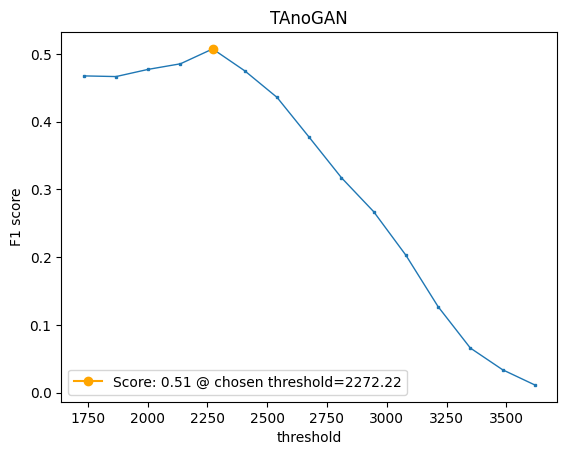


Precision score:
1733.6695556640625: 0.30526315789473685
1868.3079572405134: 0.30550621669627
2002.9463588169642: 0.31647940074906367
2137.5847603934153: 0.336283185840708
2272.223161969866: 0.3785310734463277
2406.861563546317: 0.3917910447761194
2541.499965122768: 0.41450777202072536
2676.1383666992188: 0.4244604316546763
2810.7767682756694: 0.44329896907216493
2945.4151698521205: 0.5344827586206896
3080.0535714285716: 0.6363636363636364
3214.691973005022: 0.8
3349.3303745814733: 0.75
3483.9687761579244: 1.0
3618.607177734375: 1.0


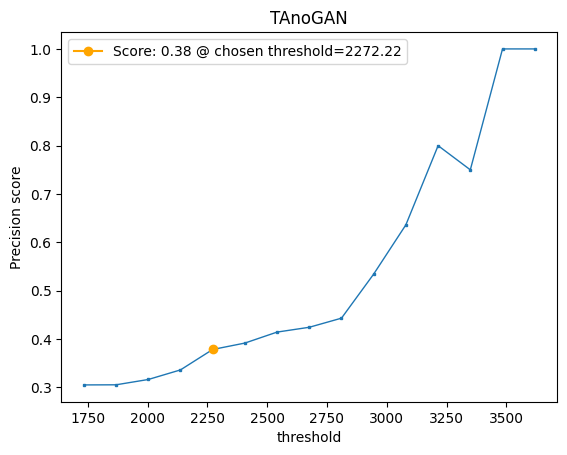


Recall score:
1733.6695556640625: 1.0
1868.3079572405134: 0.9885057471264368
2002.9463588169642: 0.9712643678160919
2137.5847603934153: 0.8735632183908046
2272.223161969866: 0.7701149425287356
2406.861563546317: 0.603448275862069
2541.499965122768: 0.45977011494252873
2676.1383666992188: 0.3390804597701149
2810.7767682756694: 0.2471264367816092
2945.4151698521205: 0.1781609195402299
3080.0535714285716: 0.1206896551724138
3214.691973005022: 0.06896551724137931
3349.3303745814733: 0.034482758620689655
3483.9687761579244: 0.017241379310344827
3618.607177734375: 0.005747126436781609


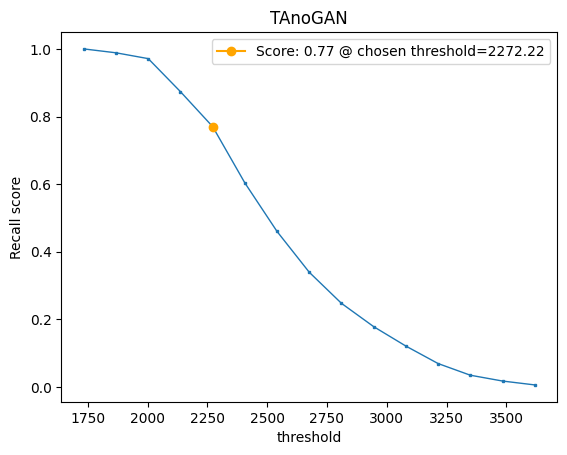

In [ ]:
losses = np.concatenate((test_loss, validation_loss))
labels = np.concatenate((labels_rec1, labels_rec5))

compute_metrics(losses, labels, "TAnoGAN", num_thresholds=15)

In [21]:
def roc_plot(losses, labels, plot_title, num_thresholds=10):
  min_threshold = losses.min()
  max_threshold = losses.max()

  thresholds = np.linspace(start=min_threshold, stop=max_threshold, num=15)

  sens = list()
  fpr = list()
  for threshold in thresholds:
    predicted_labels = (losses >= threshold).astype(int)  # losses above threshold are predicted as anomaly

    matching = (predicted_labels == labels).astype(int)
    tp = matching[predicted_labels==1].astype(int).sum()

    cm_anomaly = np.zeros((2, 2))
    n_samples = len(losses)
    n_not_collisions = n_samples - sum(labels)
    n_detected = sum(predicted_labels)

    fp = n_detected - tp
    fn = sum(labels) - tp
    tn = n_not_collisions - fp

    sens.append(tp / (tp + fn))
    fpr.append(1-tn /(fp + tn))

  fig, ax = plt.subplots(1, 1)
  ax.plot(fpr, sens)
  plt.title(plot_title)

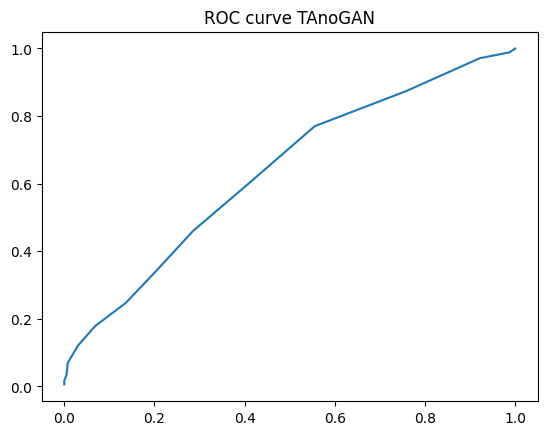

In [23]:
roc_plot(losses, labels, "ROC curve TAnoGAN", 15)


F1 score
1733.6695556640625: 0.3099415204678363
1856.9249180385045: 0.30267062314540055
1980.1802804129463: 0.30573248407643316
2103.435642787388: 0.3076923076923077
2226.69100516183: 0.2941176470588235
2349.946367536272: 0.2545454545454545
2473.201729910714: 0.2706766917293233
2596.4570922851562: 0.23636363636363636
2719.7124546595983: 0.20833333333333334
2842.9678170340403: 0.13157894736842107
2966.223179408482: 0.0967741935483871
3089.4785417829244: 0.034482758620689655
3212.733904157366: 0.03636363636363636
3335.989266531808: 0.037037037037037035
3459.24462890625: 0.037037037037037035


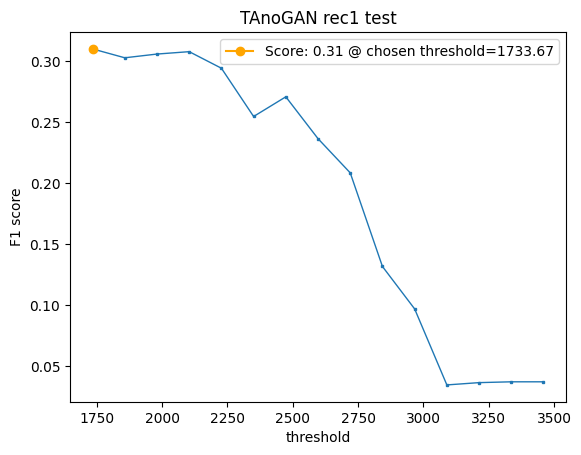


Precision score:
1733.6695556640625: 0.18339100346020762
1856.9249180385045: 0.1795774647887324
1980.1802804129463: 0.1839080459770115
2103.435642787388: 0.1932367149758454
2226.69100516183: 0.1986754966887417
2349.946367536272: 0.1875
2473.201729910714: 0.225
2596.4570922851562: 0.22807017543859648
2719.7124546595983: 0.23255813953488372
2842.9678170340403: 0.21739130434782608
2966.223179408482: 0.3333333333333333
3089.4785417829244: 0.2
3212.733904157366: 0.5
3335.989266531808: 1.0
3459.24462890625: 1.0


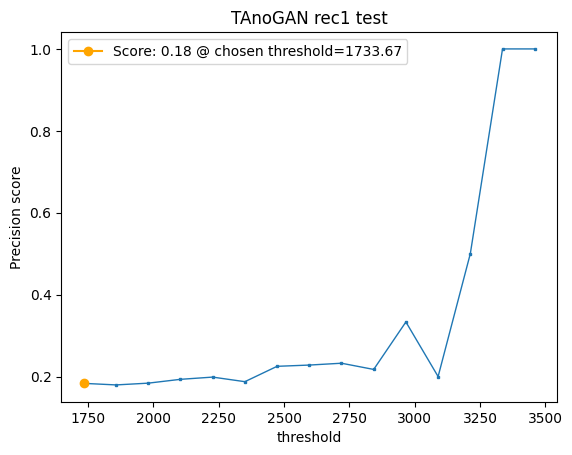


Recall score:
1733.6695556640625: 1.0
1856.9249180385045: 0.9622641509433962
1980.1802804129463: 0.9056603773584906
2103.435642787388: 0.7547169811320755
2226.69100516183: 0.5660377358490566
2349.946367536272: 0.39622641509433965
2473.201729910714: 0.33962264150943394
2596.4570922851562: 0.24528301886792453
2719.7124546595983: 0.18867924528301888
2842.9678170340403: 0.09433962264150944
2966.223179408482: 0.05660377358490566
3089.4785417829244: 0.018867924528301886
3212.733904157366: 0.018867924528301886
3335.989266531808: 0.018867924528301886
3459.24462890625: 0.018867924528301886


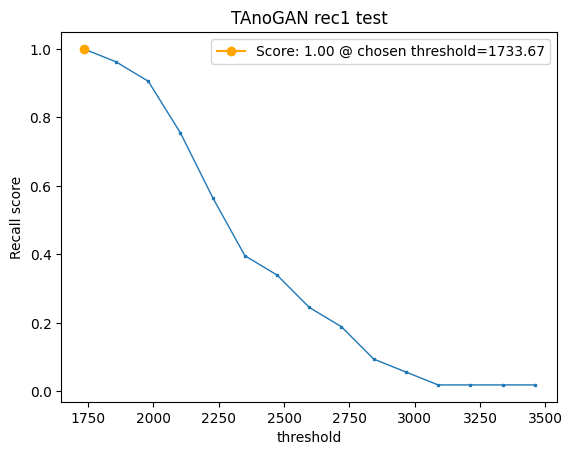

In [20]:
# test only on rec1
compute_metrics(test_loss, labels_rec1, "TAnoGAN rec1 test", num_thresholds=15)


F1 score
1991.4395751953125: 0.6019900497512437
2107.6658325195312: 0.6102564102564102
2223.89208984375: 0.6285714285714286
2340.1183471679688: 0.620253164556962
2456.3446044921875: 0.5367647058823529
2572.5708618164062: 0.5126050420168068
2688.797119140625: 0.4423076923076923
2805.0233764648438: 0.38743455497382195
2921.2496337890625: 0.34682080924855485
3037.4758911132812: 0.27272727272727276
3153.7021484375: 0.2014388489208633
3269.9284057617188: 0.15037593984962405
3386.1546630859375: 0.06299212598425197
3502.3809204101562: 0.032520325203252036
3618.607177734375: 0.01639344262295082


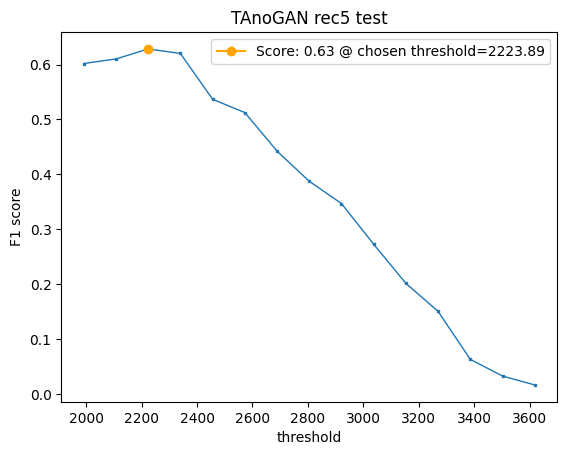


Precision score:
1991.4395751953125: 0.4306049822064057
2107.6658325195312: 0.4423791821561338
2223.89208984375: 0.48034934497816595
2340.1183471679688: 0.5025641025641026
2456.3446044921875: 0.48344370860927155
2572.5708618164062: 0.5213675213675214
2688.797119140625: 0.5287356321839081
2805.0233764648438: 0.5285714285714286
2921.2496337890625: 0.5769230769230769
3037.4758911132812: 0.6363636363636364
3153.7021484375: 0.7777777777777778
3269.9284057617188: 0.8333333333333334
3386.1546630859375: 0.6666666666666666
3502.3809204101562: 1.0
3618.607177734375: 1.0


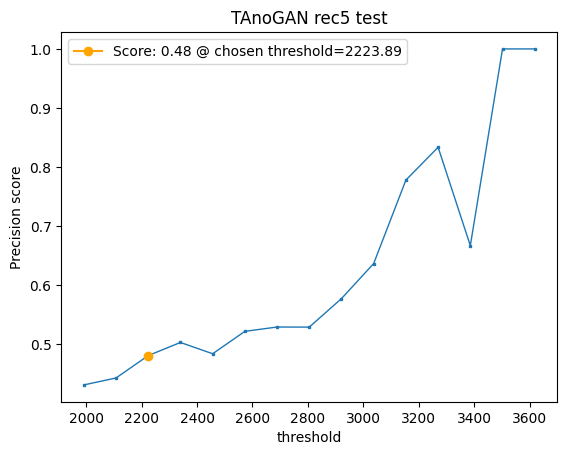


Recall score:
1991.4395751953125: 1.0
2107.6658325195312: 0.9834710743801653
2223.89208984375: 0.9090909090909091
2340.1183471679688: 0.8099173553719008
2456.3446044921875: 0.6033057851239669
2572.5708618164062: 0.5041322314049587
2688.797119140625: 0.38016528925619836
2805.0233764648438: 0.30578512396694213
2921.2496337890625: 0.24793388429752067
3037.4758911132812: 0.17355371900826447
3153.7021484375: 0.11570247933884298
3269.9284057617188: 0.08264462809917356
3386.1546630859375: 0.03305785123966942
3502.3809204101562: 0.01652892561983471
3618.607177734375: 0.008264462809917356


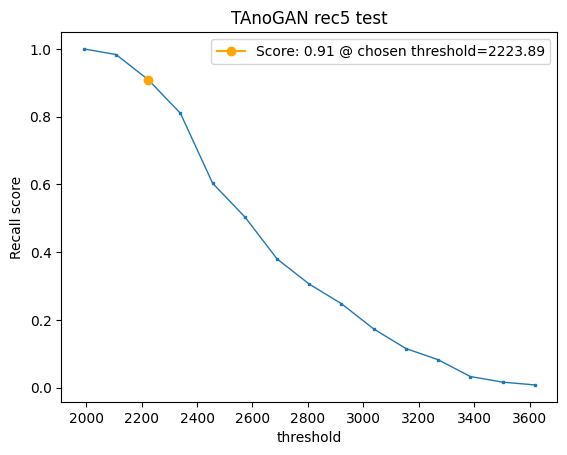

In [19]:
#losses = np.concatenate((test_loss, validation_loss))
#labels = np.concatenate((labels_rec1, labels_rec5))

#compute_metrics(test_loss, labels_rec1, "TAnoGAN rec1 test", num_thresholds=15)
# test only on rec5
compute_metrics(validation_loss, labels_rec5, "TAnoGAN rec5 test", num_thresholds=15)